## Noisy RGB pixels, (Conv + UNet + Residual + Conv + Residual) on individual RGB color channels, 1/8 U-Net bottleneck, L1/L2 + Perceptual + Adversarial + Color Correction Loss

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from plot_data import load_data

import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def load_data_file(filename, verbose=False):
    bufferview = load_data(filename)
    images = {}
    img_sum = 0.0 * bufferview[0]['buffer']
    w = 0.0
    for image in bufferview:
        images[image['name']] = image['buffer']
        if not image['name'] >= 1:
            continue
        w += image['name']
        img_sum += image['name'] * image['buffer']

    # noise images less than 1spp
    sub = []
    for e in range(1, 4+1, 1):
        spp = 2**(-e)
        if spp not in images:
            break
        img = np.nan_to_num(images[spp], nan=0.0, posinf=0.0, neginf=0.0)
        sub.append(img)

    # power of 2 images greater than 1spp
    data = []
    for e in range(0, len(images)-len(sub)):
        spp = 2**e
        if spp not in images:
            break
        data.append(images[spp])
    data = np.array(data)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    # reference image, denoise with oidn
    ref = img_sum / w
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2

    if verbose:
        print(len(sub), data.shape, data.dtype, ref.shape, ref.dtype)
        plot_frame(ref**(1.0/2.2))
    return {
        'sub': sub,
        'data': data,
        'ref': ref
    }

# _ = load_data_file("data/implicit3-rt_0c2c00f9b182_1024.bin", verbose=True)

torch.Size([8, 3, 256, 256])


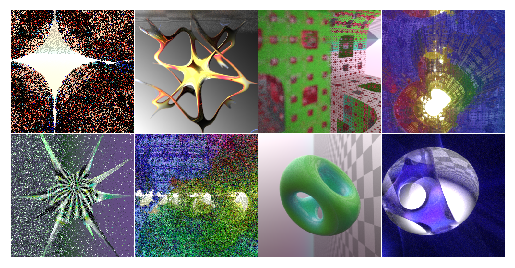

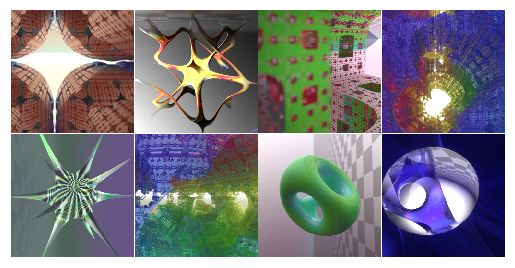

In [3]:
import random

class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = []
        for root, dirs, files in os.walk('data/'):
            for filename in files:
                filename = os.path.join(root, filename)
                try:
                    self.data.append(load_data_file(filename))
                except:
                    pass
        self.n = n
    
    def __len__(self):
        return self.n

    def __getitem__(self, i):

        # random data
        img = self.data[random.randint(0,len(self.data)-1)]
        clean = img['ref']

        # random chance to get <1spp image
        if random.random() < 0.0:
            noisy = random.choice(img['sub'])

        # clean image - random spp, sample from spp
        else:
            n = img['data'].shape[0]
            spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
            total = 0.0
            weight = 0.0
            for _ in range(n):
                if (spp >> _) & 1 == 0:
                    continue
                frame = img['data'][_]
                dw = ((frame > 0.0) & (frame < 1e6)).astype(np.float32) * 2**_
                total += frame * dw
                weight += dw
            noisy = total / np.fmax(weight, 1.0)

        # random flip/rotate/transpose
        if random.random() < 0.5:
            noisy = np.flip(noisy, 0)
            clean  = np.flip(clean,  0)
        if random.random() < 0.5:
            noisy = np.flip(noisy, 1)
            clean = np.flip(clean, 1)
        if random.random() < 0.5:
            noisy = np.swapaxes(noisy,  1, 2)
            clean = np.swapaxes(clean, 1, 2)

        # random swap color channels
        cidx = [0, 1, 2]
        random.shuffle(cidx)
        noisy = noisy[cidx]
        clean = clean[cidx]

        return [
            np.fmax(noisy, 0.0) ** (1.0/2.2),
            np.fmax(clean, 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:8].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x, inplace=True):
    return F.relu(x, inplace)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0, n1, n2, n3 = 8, 12, 16, 20
        self.convi = conv3(1, n0)
        self.econv0a = conv3(n0, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1a = conv3(n0, n1) # 1/2
        self.econv1b = conv3(n1, n1) # 1/2
        self.econv2a = conv3(n1, n2) # 1/4
        self.econv2b = conv3(n2, n2) # 1/4
        self.econv3a = conv3(n2, n3) # 1/8
        self.econv3b = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv1(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv1(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv1(n0+n0, n0) # 1
        self.convo = conv3(n0, 1)

    def forward(self, input):
        xi = input.reshape((-1, 1, *input.shape[2:]))
        ci = self.convi(xi)
        e0 = self.econv0b(relu(self.econv0a(relu(ci, False)))) # 1
        e1 = self.econv1b(relu(self.econv1a(pool(e0)))) # 1/2
        e2 = self.econv2b(relu(self.econv2a(pool(e1)))) # 1/4
        e3 = self.econv3b(relu(self.econv3a(pool(e2)))) # 1/8
        d2 = relu(self.dconv2a(relu(e3))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        xo = self.convo(ci+do)+xi
        return xo.view_as(input)


model = Model().to(device)
x = torch.randn((8, 3, 256, 256), device=device)
with torch.no_grad():
    y = model(x)
print(y.shape)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total', num_params, 'parameters')

print(model)

torch.Size([8, 3, 256, 256])
Total 24817 parameters
Model(
  (convi): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0a): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1a): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2a): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3a): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3b): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(20, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (dconv1a): ConvTranspose2d(16, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [5]:
"""Image Denoising Using A Generative Adversarial Network,
    Code modified from implementation by Jeffrey Ming Han Li"""

class Discriminator(torch.nn.Module):
    def __init__(self,K2):
        super(Discriminator, self).__init__()

        # Basic convolutional block
        def conv_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(0.01, inplace=True)
            )
        def last_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Sigmoid()
            )

        self.model = torch.nn.Sequential(
            conv_block(3,K2, kernel_size=4, stride=2),
            conv_block(K2,3*K2//2, kernel_size=4, stride=2),
            conv_block(3*K2//2,K2*2, kernel_size=4, stride=2),
            conv_block(K2*2,K2*3, kernel_size=4, stride=2),
            conv_block(K2*3,K2*4, kernel_size=4, stride=2),
            conv_block(K2*4,K2*4, kernel_size=3, stride=1),
            last_block(K2*4,1, kernel_size=3, stride=1)
        )

    def forward(self, x):
        y = self.model(x)
        # print(y.shape)
        return torch.clip(torch.mean(y, axis=(2, 3)), 0.0, 1.0)


class CombinedLoss(torch.nn.Module):
    def __init__(self, lambda_a, lambda_p, lambda_f, lambda_c, device='cpu'):
        super(CombinedLoss, self).__init__()
        self.lambda_a = lambda_a  # adversarial
        self.lambda_p = lambda_p  # pixel loss
        self.lambda_f = lambda_f  # feature loss (perceptual)
        # self.lambda_t = lambda_t  # texture matching loss
        self.lambda_t = 0.0
        self.lambda_c = lambda_c  # correct color shift caused by GAN

        # loss function for GAN
        self.bce = torch.nn.BCEWithLogitsLoss()

        # VGG16 model for feature and texture loss
        import torchvision.models
        vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

        # vgg first layer
        self.feature_extractor = vgg16.features[:4].to(device)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.feature_extractor_1 = lambda x: self.feature_extractor((x-vgg_mean)/vgg_std)
        # print(self.feature_extractor)

        # vgg second layer, after first layer
        self.feature_extractor_2 = vgg16.features[4:9].to(device)
        for param in self.feature_extractor_2.parameters():
            param.requires_grad = False
        # print(self.feature_extractor_2)
    
    @staticmethod
    def gram(x, s):
        if x.shape[2] % s != 0 or x.shape[3] % s != 0:
            raise ValueError("Image dimension not multiple of texture patch size")
        x = x.view(x.shape[0], x.shape[1], x.shape[2]//s, s, x.shape[3]//s, s)
        x = x.permute(0, 1, 2, 4, 3, 5).contiguous()
        x = x.view(x.shape[0], x.shape[1], -1, s*s)
        g = torch.matmul(x, x.transpose(3, 2))
        return g / (s*s)
    
    @staticmethod
    def mask_non_finite(x, v):
        nan_mask = torch.isnan(x)
        inf_mask = torch.isinf(x)
        x[nan_mask] = v
        x[inf_mask] = v
        return x
    
    def forward(self, generated, target, discriminator_output, is_discriminator=False):
        # normalization parameters
        normalize_l2 = 1.0 / 0.05  # change this to estimated L1 loss
        normalize_vgg = 1.0 / 0.225
        normalize_l2_vgg = normalize_l2 / normalize_vgg
        normalize_l2_vgg_gram = normalize_l2_vgg ** 2

        # adversarial Loss
        if is_discriminator:
            return self.bce(discriminator_output, target)
        # loss_a = -torch.mean(discriminator_output)
        loss_a = self.bce(1.0-discriminator_output, torch.ones_like(discriminator_output))

        # pixel loss (L1+L2)
        loss_p2 = torch.mean((generated-target)**2) * normalize_l2
        loss_p1 = torch.mean(torch.abs(generated-target))
        loss_p = 0.5*(loss_p1+loss_p2)

        # feature loss (L1+L2)
        gen_features = self.feature_extractor_1(generated)
        tgt_features = self.feature_extractor_1(target)
        loss_f1l2 = torch.mean((gen_features-tgt_features)**2) * normalize_l2_vgg
        loss_f1l1 = torch.mean(torch.abs(gen_features-tgt_features))
        gen_features_2 = self.feature_extractor_2(gen_features)
        tgt_features_2 = self.feature_extractor_2(tgt_features)
        loss_f2l2 = torch.mean((gen_features_2-tgt_features_2)**2) * normalize_l2_vgg
        loss_f2l1 = torch.mean(torch.abs(gen_features_2-tgt_features_2))
        loss_f = 0.25*(loss_f1l2+loss_f1l1+loss_f2l2+loss_f2l1)

        # texture loss
        # loss_t1 = torch.mean(self.gram(gen_features,16)-self.gram(tgt_features,16))**2
        # # loss_t2 = torch.mean(self.gram(gen_features_2,8)-self.gram(tgt_features_2,8))**2
        # loss_t2 = torch.mean(self.gram(gen_features_2,16)-self.gram(tgt_features_2,16))**2
        # loss_t = (0.5*(loss_t1+loss_t2))**0.5 * normalize_l2_vgg_gram
        loss_t = 0.0

        # color correction loss
        output_size = (7, 7)  # non power of 2 to break tiles
        generated_mapped = torch.nn.functional.interpolate(
            torch.clip(torch.exp(generated)-1.0,0.0,1e3)**2.2, output_size, mode="bilinear")
        target_mapped = torch.nn.functional.interpolate(
            torch.clip(torch.exp(target)-1.0,0.0,1e3)**2.2, output_size, mode="bilinear")
        generated_mapped = self.mask_non_finite(generated_mapped, 0.0)
        target_mapped = self.mask_non_finite(target_mapped, 0.0)
        eps = 0.01
        loss_c_log = torch.mean(
            generated_mapped/(target_mapped+eps) + \
            target_mapped/(generated_mapped+eps) - 2.0
        ) * normalize_l2
        loss_c_l2 = torch.mean(torch.log((generated_mapped-target_mapped)**2+1.0)) * normalize_l2
        loss_c_l1 = torch.mean(torch.log(torch.abs(generated_mapped-target_mapped)+1.0))
        loss_c = 0.4*loss_c_log + 0.3*loss_c_l2 + 0.3*loss_c_l1

        # composite loss
        total_loss = \
            self.lambda_a * loss_a + \
            self.lambda_p * loss_p + \
            self.lambda_f * loss_f + \
            self.lambda_t * loss_t + \
            self.lambda_c * loss_c
        # print(loss_a.item(), loss_p.item(), loss_f.item(), loss_t.item(), loss_c.item())

        return total_loss


discriminator = Discriminator(16).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

In [6]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = 0.005)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=10, min_lr=0.00005)
scheduler_d = lr_scheduler.ReduceLROnPlateau(
    optimizer_d, mode='min', factor=0.3, patience=10, min_lr=0.0001)

enable_epoch = 32

# model 0: (1.0, 1.0, 1.0, 0.2), lr=(0.002,0.005), f=0.3, mlr=(0.00005,0.0001), ee=32
lossfun = CombinedLoss(0.0, 1.0, 1.0, 0.2, device)

Ready
1 g 4.95445275604725 2.3887558430433273 d 1.4374374151229856 1.4312995225191116
2 g 2.1156976938247682 1.8344846367835999 d 1.426788640022278 1.4219215363264084
3 g 1.7592586517333986 1.668506771326065 d 1.4185187965631485 1.4144744575023651
4 g 1.7034428641200066 1.5304041355848312 d 1.4123173177242276 1.4090459793806076
5 g 1.575144138932228 1.5056913048028946 d 1.4072213500738147 1.4048272222280502
6 g 1.4570127785205838 1.3590208142995834 d 1.40359480381012 1.4015800803899765
7 g 1.4161915369331834 1.333430215716362 d 1.400829216837883 1.3994810581207275
8 g 1.3682258307933806 1.2789208441972733 d 1.3985734909772871 1.3973791599273682
9 g 1.3286992400884632 1.2613691240549088 d 1.3969782322645188 1.39579376578331
10 g 1.228138813376427 1.2046961560845375 d 1.3953496932983398 1.3943692594766617
11 g 1.1770065590739252 1.0651851370930672 d 1.3942342042922977 1.3933161199092865
12 g 1.0202242672443391 1.0348344072699547 d 1.3932799071073534 1.3928153961896896
13 g 1.059264177083

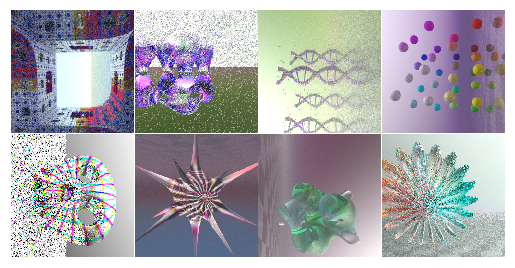

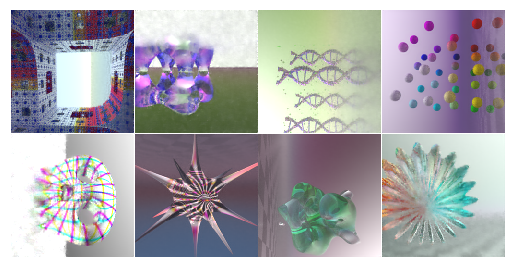

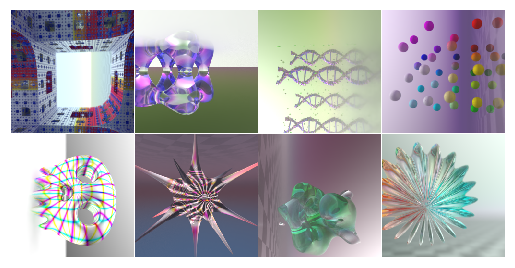

Enable epoch
33 g 1.469775107502938 1.2517400830984116 d 1.3869599193334583 1.388831004500389 lr 0.002 0.005
34 g 1.2726852238178252 1.1924465000629425 d 1.3876368403434751 1.3880144655704498 lr 0.002 0.005
35 g 1.1779448494315146 1.2019798755645752 d 1.3868783593177794 1.3871194124221802 lr 0.002 0.005
36 g 1.2382714539766313 1.2043194398283958 d 1.3869922429323196 1.3871122896671295 lr 0.002 0.005
37 g 1.1801355361938477 1.18305291980505 d 1.3873992651700973 1.3869075924158096 lr 0.002 0.005
38 g 1.129500187933445 1.1876994371414185 d 1.3868103981018063 1.38672836124897 lr 0.002 0.005
39 g 1.1365919217467308 1.192340075969696 d 1.3870531499385834 1.3867279887199402 lr 0.002 0.005
40 g 1.1572823747992518 1.173545055091381 d 1.386750167608261 1.386692836880684 lr 0.002 0.005
41 g 1.0956860944628715 1.1818892359733582 d 1.386489716172218 1.3867608904838562 lr 0.002 0.005
42 g 1.16511337608099 1.1633776873350143 d 1.3867091834545133 1.3871125876903534 lr 0.002 0.005
43 g 1.16390895247459

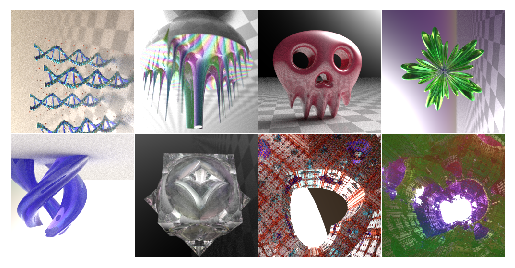

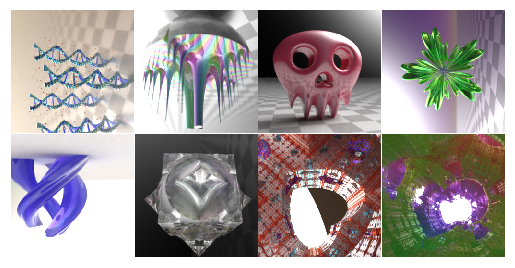

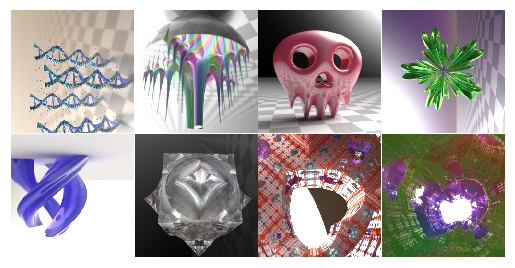

65 g 1.076487085223198 1.1566118970513344 d 1.35663016140461 1.3579985350370407 lr 0.002 0.005
66 g 1.064958517253399 1.1122051924467087 d 1.3261699765920638 1.336526483297348 lr 0.002 0.005
67 g 1.122594909369945 1.1573936939239502 d 1.339645367860794 1.3578555434942245 lr 0.002 0.005
68 g 1.0678747534751891 1.141919106245041 d 1.3162378817796707 1.317563757300377 lr 0.002 0.005
69 g 1.1269366726279257 1.1139594614505768 d 1.282776579260826 1.2715745270252228 lr 0.002 0.005
70 g 1.0273949876427648 1.1419084668159485 d 1.2710623025894165 1.325145184993744 lr 0.002 0.005
71 g 1.1666582897305486 1.3125017434358597 d 1.3147064924240108 1.2661811113357544 lr 0.002 0.005
72 g 1.1632431924343107 1.1700390130281448 d 1.2570901483297348 1.2860758006572723 lr 0.002 0.005
73 g 1.1366693273186685 1.2027312144637108 d 1.2368859261274339 1.214657500386238 lr 0.0006 0.005
74 g 1.1306206941604617 1.0959651917219162 d 1.2207963675260542 1.2105126678943634 lr 0.0006 0.005
75 g 1.1488289698958398 1.1633

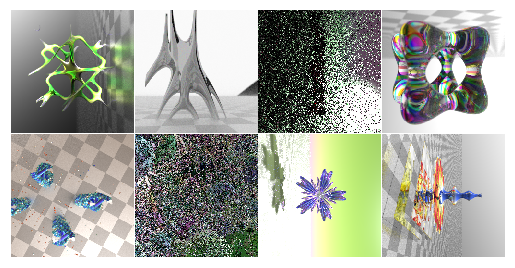

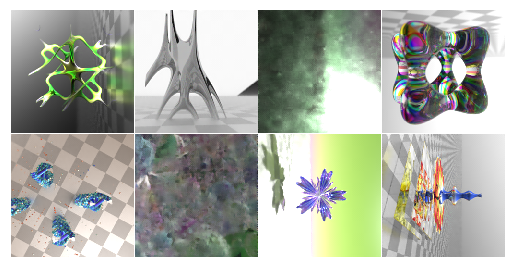

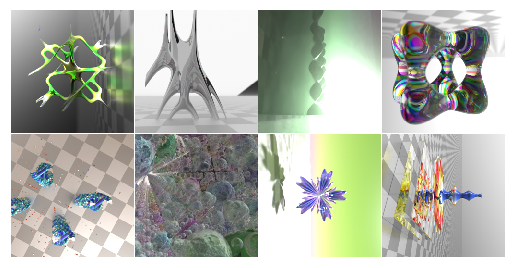

97 g 1.0807902038097381 1.0808017998933792 d 1.1572557300329207 1.1415881961584091 lr 0.00017999999999999998 0.005
98 g 1.0255056962370872 1.0731875449419022 d 1.133374109864235 1.1257474422454834 lr 0.00017999999999999998 0.005
99 g 1.100590877234936 1.1960691064596176 d 1.1639568299055103 1.3185554146766663 lr 0.00017999999999999998 0.005
100 g 0.998099546134472 1.0858963131904602 d 1.372545716166497 1.3939268290996552 lr 0.00017999999999999998 0.005
101 g 1.0496785566210747 1.0833153650164604 d 1.3926992893218997 1.3920051902532578 lr 0.00017999999999999998 0.005
102 g 1.0681518346071242 1.079625628888607 d 1.391947853565216 1.390014111995697 lr 0.00017999999999999998 0.005
103 g 1.025992967933416 1.0792594999074936 d 1.3901972264051434 1.389173448085785 lr 0.00017999999999999998 0.005
104 g 1.0757239252328872 1.0813000425696373 d 1.3896707475185395 1.3891934603452682 lr 0.00017999999999999998 0.005
105 g 1.0063619427382948 1.0740757584571838 d 1.3873811632394792 1.3899315297603607 

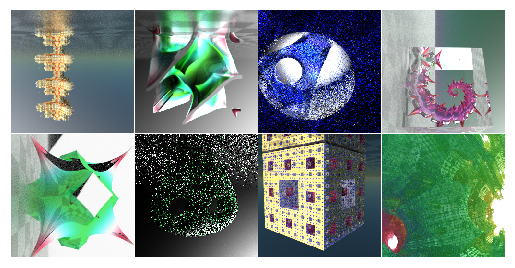

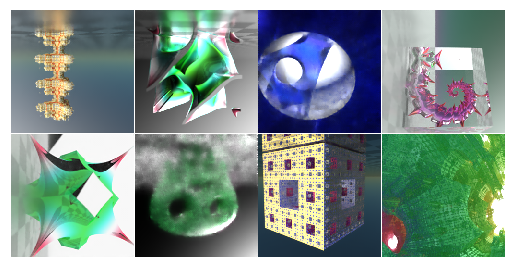

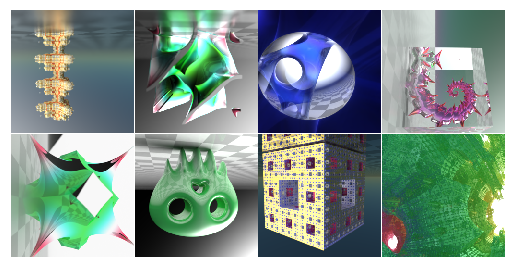

129 g 1.0398228883743288 1.0602586790919304 d 1.1107399493455885 1.1087603718042374 lr 0.00017999999999999998 0.0015
130 g 1.059481508284807 1.0599295124411583 d 1.1101193726062772 1.1079923808574677 lr 0.00017999999999999998 0.0015
131 g 1.0791004344820974 1.0571513697504997 d 1.109189110994339 1.1088559478521347 lr 0.00017999999999999998 0.0015
132 g 1.0537752509117126 1.0544476956129074 d 1.1082244664430618 1.1078229248523712 lr 0.00017999999999999998 0.0015
133 g 0.9868550047278406 1.0593157708644867 d 1.108073130249977 1.1065867841243744 lr 0.00017999999999999998 0.0015
134 g 1.0847836256027221 1.0597637221217155 d 1.1077668845653534 1.1070336252450943 lr 0.00017999999999999998 0.0015
135 g 1.1020607948303225 1.0555027574300766 d 1.1062083005905154 1.1061669439077377 lr 0.00017999999999999998 0.0015
136 g 0.9814523689448834 1.0560907945036888 d 1.1076430052518846 1.1076970547437668 lr 0.00017999999999999998 0.0015
137 g 1.081622502207756 1.05617006868124 d 1.1068836599588394 1.106

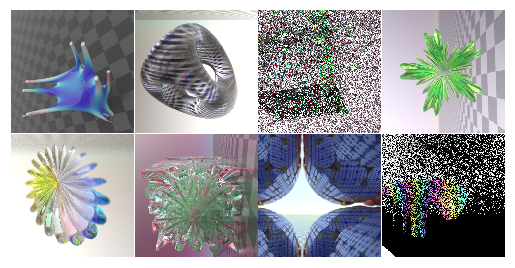

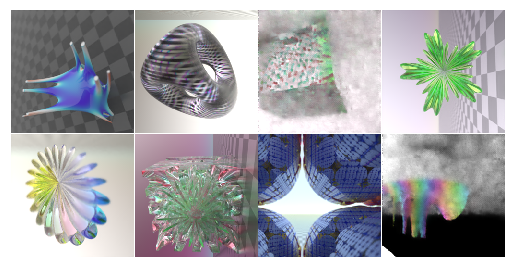

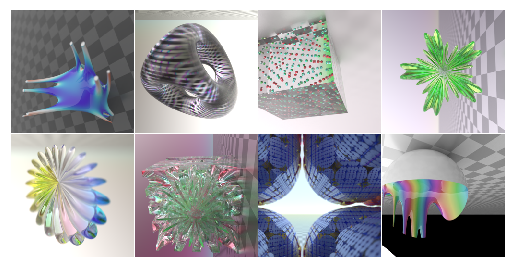

161 g 0.9686785638332366 1.045227773487568 d 1.0967401444911957 1.0961889773607254 lr 0.00017999999999999998 0.0015
162 g 1.0221088409423826 1.0449931994080544 d 1.0963343739509581 1.0961502343416214 lr 0.00017999999999999998 0.0015
163 g 0.9949964791536331 1.0452157035470009 d 1.0966692537069325 1.0965000241994858 lr 0.00017999999999999998 0.0015
164 g 1.0571818828582764 1.0431669130921364 d 1.098091235756874 1.097862422466278 lr 0.00017999999999999998 0.0015
165 g 1.0526718735694887 1.0511122718453407 d 1.113002967834473 1.0986188501119614 lr 0.00017999999999999998 0.0015
166 g 0.9870901986956594 1.0529318451881409 d 1.097339504957199 1.0959409475326538 lr 0.00017999999999999998 0.0015
167 g 1.0170068487524986 1.0460576713085175 d 1.09572491645813 1.0957573801279068 lr 0.00017999999999999998 0.0015
168 g 1.0797431513667108 1.0459570065140724 d 1.0958446919918061 1.096614882349968 lr 0.00017999999999999998 0.0015
169 g 1.0697395130991934 1.0419538095593452 d 1.0956648528575896 1.09618

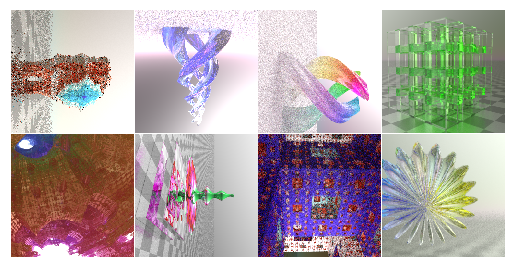

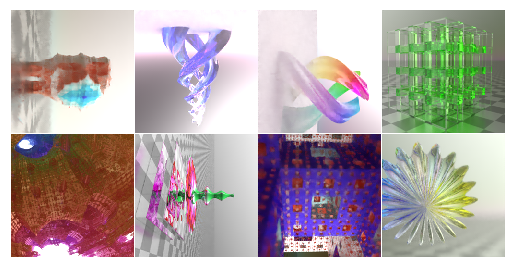

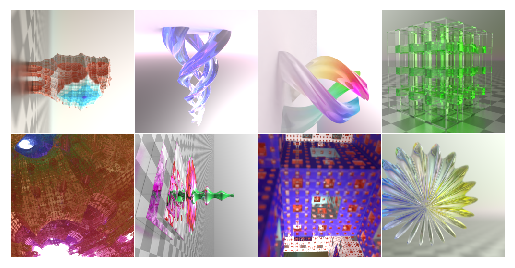

193 g 1.0568232208490378 1.0395456105470657 d 1.1096149086952214 1.108386904001236 lr 5.399999999999999e-05 0.00045
194 g 0.9869372501969337 1.0381150990724564 d 1.1075835287570959 1.107152447104454 lr 5.399999999999999e-05 0.00045
195 g 1.0105623126029968 1.038327917456627 d 1.1075056165456774 1.1066192239522934 lr 5.399999999999999e-05 0.000135
196 g 1.0530307114124298 1.0381306111812592 d 1.1067868828773495 1.106738954782486 lr 5.399999999999999e-05 0.000135
197 g 1.005124107003212 1.0393015071749687 d 1.1067097395658492 1.1064948737621307 lr 5.399999999999999e-05 0.000135
198 g 1.0613655433058737 1.038867361843586 d 1.1063128769397736 1.1059852540493011 lr 5.399999999999999e-05 0.000135
199 g 1.037655022740364 1.0377396047115326 d 1.1053895711898805 1.1061732023954391 lr 5.399999999999999e-05 0.000135
200 g 1.0178436487913132 1.037114940583706 d 1.1059285521507265 1.1055724620819092 lr 5.399999999999999e-05 0.000135
201 g 1.0541290774941443 1.0392380207777023 d 1.106279477477074 1.

In [7]:
discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

batch_size = 24  # how much RAM do I have?
batch_per_epoch = 40
batch_per_epoch_val = 8

num_epoch = 1024

dataset = RawDataset(batch_size*batch_per_epoch)

valloader = []
for x, y in torch.utils.data.DataLoader(dataset, batch_size=batch_size):
    valloader.append((x, y))
    if len(valloader) >= batch_per_epoch_val:
        break

print("Ready")

for epoch in range(num_epoch):
    if epoch == enable_epoch:
        print("Enable epoch")
        lossfun.lambda_a = 1.0
        from collections import defaultdict
        optimizer.__setstate__({'state': defaultdict(dict)})
        optimizer_d.__setstate__({'state': defaultdict(dict)})

    # training
    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)
    mean_loss_g, mean_loss_d = 0.0, 0.0
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        g_loss.backward()
        optimizer.step()

        mean_loss_g += g_loss.item() / batch_per_epoch
        mean_loss_d += d_loss.item() / batch_per_epoch
    
    # validation
    mean_loss_gv, mean_loss_dv = 0.0, 0.0
    with torch.no_grad():
        for x, y in valloader:
            x = x.to(device)
            y = y.to(device)
            x = torch.log(1+x)
            y = torch.log(1+y)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_outputs = discriminator(y)
            d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

            fake_images = model(x)
            fake_outputs = discriminator(fake_images)
            d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

            d_loss = d_loss_real + d_loss_fake
            g_loss = lossfun(fake_images, y, fake_outputs)

            mean_loss_gv += g_loss.item() / batch_per_epoch_val
            mean_loss_dv += d_loss.item() / batch_per_epoch_val
    
    # scheduling / verbose
    epoch += 1
    if epoch > enable_epoch:
        scheduler.step(mean_loss_gv)
        scheduler_d.step(mean_loss_dv)
        if scheduler.get_last_lr()[0] <= scheduler.min_lrs[0]:
            break
        print(f"{epoch} g {mean_loss_g} {mean_loss_gv} d {mean_loss_d} {mean_loss_dv} lr {scheduler.get_last_lr()[0]} {scheduler_d.get_last_lr()[0]}")
    else:
        print(f"{epoch} g {mean_loss_g} {mean_loss_gv} d {mean_loss_d} {mean_loss_dv}")
    torch.save(model, "resunet2ic_1_x.pth")
    torch.save(discriminator, "resunet2ic_1_xd.pth")
    if epoch % 32 == 0:
        loader = torch.utils.data.DataLoader(dataset, batch_size=8)
        for x, y in loader:
            with torch.no_grad():
                x1 = torch.log(1+x.to(device))
                y1 = torch.exp(model(x1))-1
            plot_imgs(x)
            plot_imgs(y1)
            plot_imgs(y)
            break

print("Done")